In [1]:
import os
import openslide
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
!ls /kaggle/input/prostate-cancer-grade-assessment

sample_submission.csv  test.csv  train.csv  train_images  train_label_masks


In [3]:
BASE_DIR = '/kaggle/input/prostate-cancer-grade-assessment'

## Glimpse of the dataset

In [4]:
%%time
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(BASE_DIR, 'test.csv'))
sample_sub_df = pd.read_csv(os.path.join(BASE_DIR, 'sample_submission.csv'))

CPU times: user 23.7 ms, sys: 10.9 ms, total: 34.6 ms
Wall time: 48.8 ms


In [5]:
print(f'Number of training images: {len(os.listdir(os.path.join(BASE_DIR, "train_images")))}')
print(f'Number of segmentation masks for training: {len(os.listdir(os.path.join(BASE_DIR, "train_label_masks")))}')

Number of training images: 10616
Number of segmentation masks for training: 10516


Segmentation mask is given for almost all the training images.

In [6]:
train_df.head()

image_id data_provider  isup_grade gleason_score
0  0005f7aaab2800f6170c399693a96917    karolinska           0           0+0
1  000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0
2  0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4
3  001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4
4  001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0

In [7]:
test_df.head()

image_id data_provider
0  005700be7e06878e6605e7a5a39de1b2       radboud
1  005c6e8877caf724c600fdce5d417d40    karolinska
2  0104f76634ff89bfff1ef0804a95c380       radboud

In [8]:
sample_sub_df.head()

image_id  isup_grade
0  005700be7e06878e6605e7a5a39de1b2           0
1  005c6e8877caf724c600fdce5d417d40           0
2  0104f76634ff89bfff1ef0804a95c380           0

In [9]:
print(f'Size of train_df: {train_df.shape}')
print(f'Size of test_df: {test_df.shape}')
print(f'Size of sample_sub_df: {sample_sub_df.shape}')

Size of train_df: (10616, 4)
Size of test_df: (3, 2)
Size of sample_sub_df: (3, 2)


In [10]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set(style="whitegrid")

## Distribution of target variable

In [11]:
np.sort(pd.unique(train_df['isup_grade']))

array([0, 1, 2, 3, 4, 5])

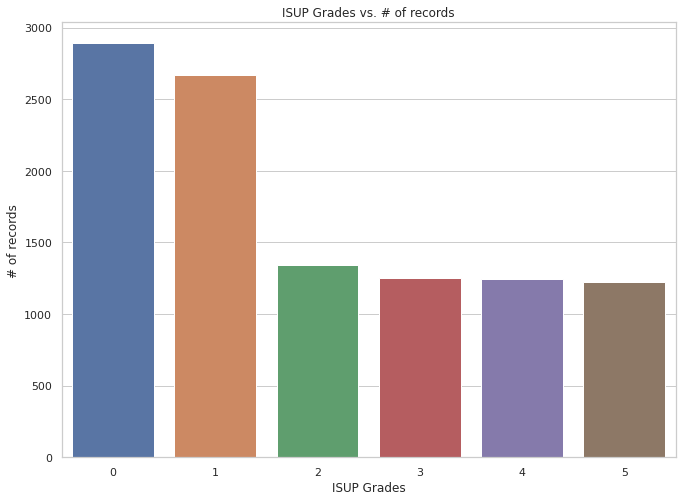

In [12]:
ax = sns.barplot(np.sort(pd.unique(train_df['isup_grade'])), train_df['isup_grade'].value_counts().sort_values(ascending=False))
ax.set(xlabel='ISUP Grades', ylabel='# of records', title='ISUP Grades vs. # of records')
plt.show()

## Distribution of Data Providers

In [13]:
train_df['data_provider'].value_counts()

karolinska    5456
radboud       5160
Name: data_provider, dtype: int64

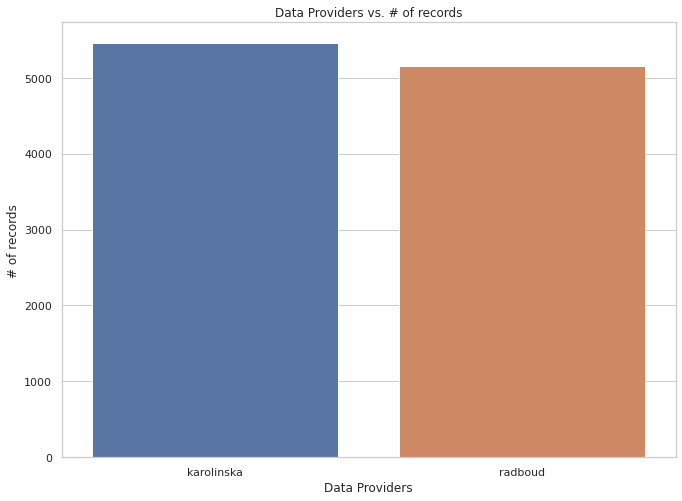

In [14]:
ax = sns.barplot(np.sort(pd.unique(train_df['data_provider'])), train_df['data_provider'].value_counts().sort_values(ascending=False))
ax.set(xlabel='Data Providers', ylabel='# of records', title='Data Providers vs. # of records')
plt.show()

## Target variable distribution based on data providers

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


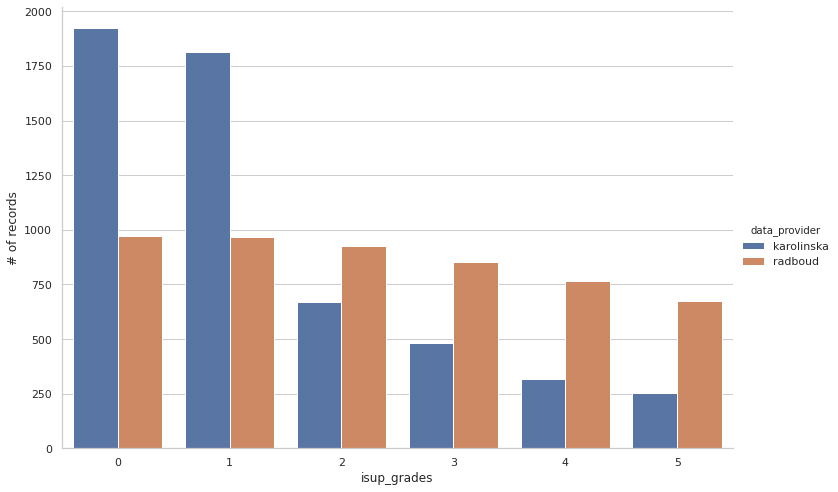

In [15]:
counts_karolinska = train_df[train_df['data_provider'] == 'karolinska']['isup_grade'].value_counts(ascending=False)
counts_radboud = train_df[~(train_df['data_provider'] == 'karolinska')]['isup_grade'].value_counts()

karolinska_df = pd.DataFrame({
    '# of records': counts_karolinska,
    'isup_grades': np.sort(pd.unique(train_df[train_df['data_provider'] == 'karolinska']['isup_grade'])),
    'data_provider': 'karolinska'
})
radboud_df = pd.DataFrame({
    '# of records': counts_radboud,
    'isup_grades': np.sort(pd.unique(train_df[~(train_df['data_provider'] == 'karolinska')]['isup_grade'])),
    'data_provider': 'radboud'
})
sns.factorplot(x='isup_grades', y='# of records', hue='data_provider', data=pd.concat([karolinska_df, radboud_df], ignore_index=True), kind='bar', height=7, aspect=1.5)
plt.show()

## Visualizing a few training images

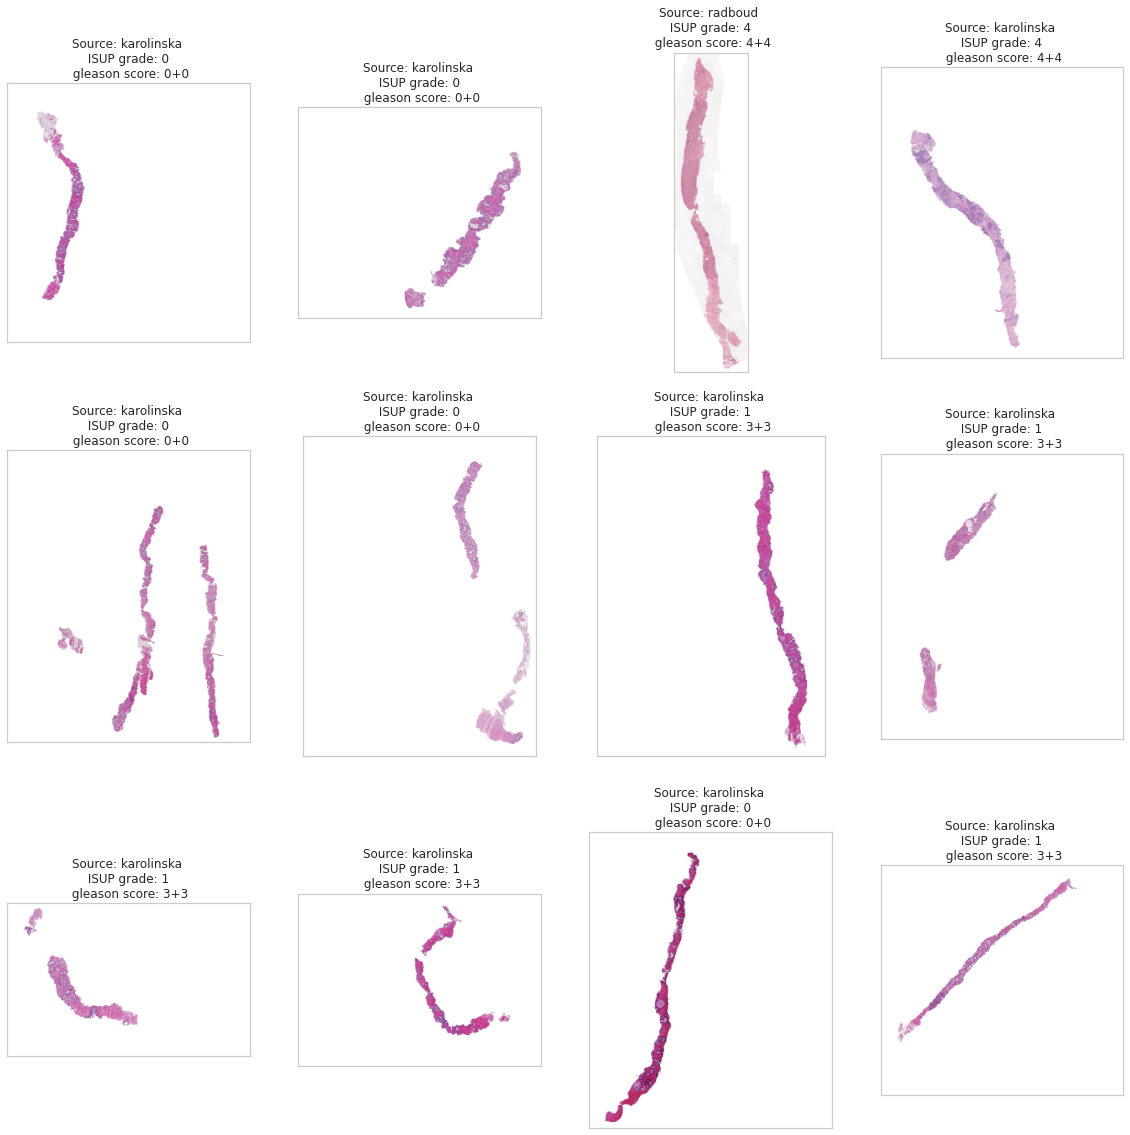

In [16]:
# Visualize few samples of current training dataset
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 20))
count=0
for row in ax:
    for col in row:
        img = os.path.join(BASE_DIR, 'train_images', f'{train_df["image_id"].iloc[count]}.tiff')
        img = openslide.OpenSlide(img)
        patch = img.read_region((0, 0), 2, img.level_dimensions[-1])
        col.title.set_text(f'Source: {train_df["data_provider"].iloc[count]} \n ISUP grade: {train_df["isup_grade"].iloc[count]} \n gleason score: {train_df["gleason_score"].iloc[count]}')
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        col.imshow(patch)
        count += 1
plt.show()

## Segmentation masks for above images

In [17]:
def print_mask_details(slide, center='radboud', show_thumbnail=True, max_size=(400,400)):
    """Print some basic information about a slide"""

    if center not in ['radboud', 'karolinska']:
        raise Exception("Unsupported palette, should be one of [radboud, karolinska].")

    # Generate a small image thumbnail
    if show_thumbnail:
        # Read in the mask data from the highest level
        # We cannot use thumbnail() here because we need to load the raw label data.
        mask_data = slide.read_region((0,0), slide.level_count - 1, slide.level_dimensions[-1])
        # Mask data is present in the R channel
        mask_data = mask_data.split()[0]

        # To show the masks we map the raw label values to RGB values
        preview_palette = np.zeros(shape=768, dtype=int)
        if center == 'radboud':
            # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
            preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
        elif center == 'karolinska':
            # Mapping: {0: background, 1: benign, 2: cancer}
            preview_palette[0:9] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 1, 0, 0]) * 255).astype(int)
        mask_data.putpalette(data=preview_palette.tolist())
        mask_data = mask_data.convert(mode='RGB')
        mask_data.thumbnail(size=max_size, resample=0)
        return mask_data

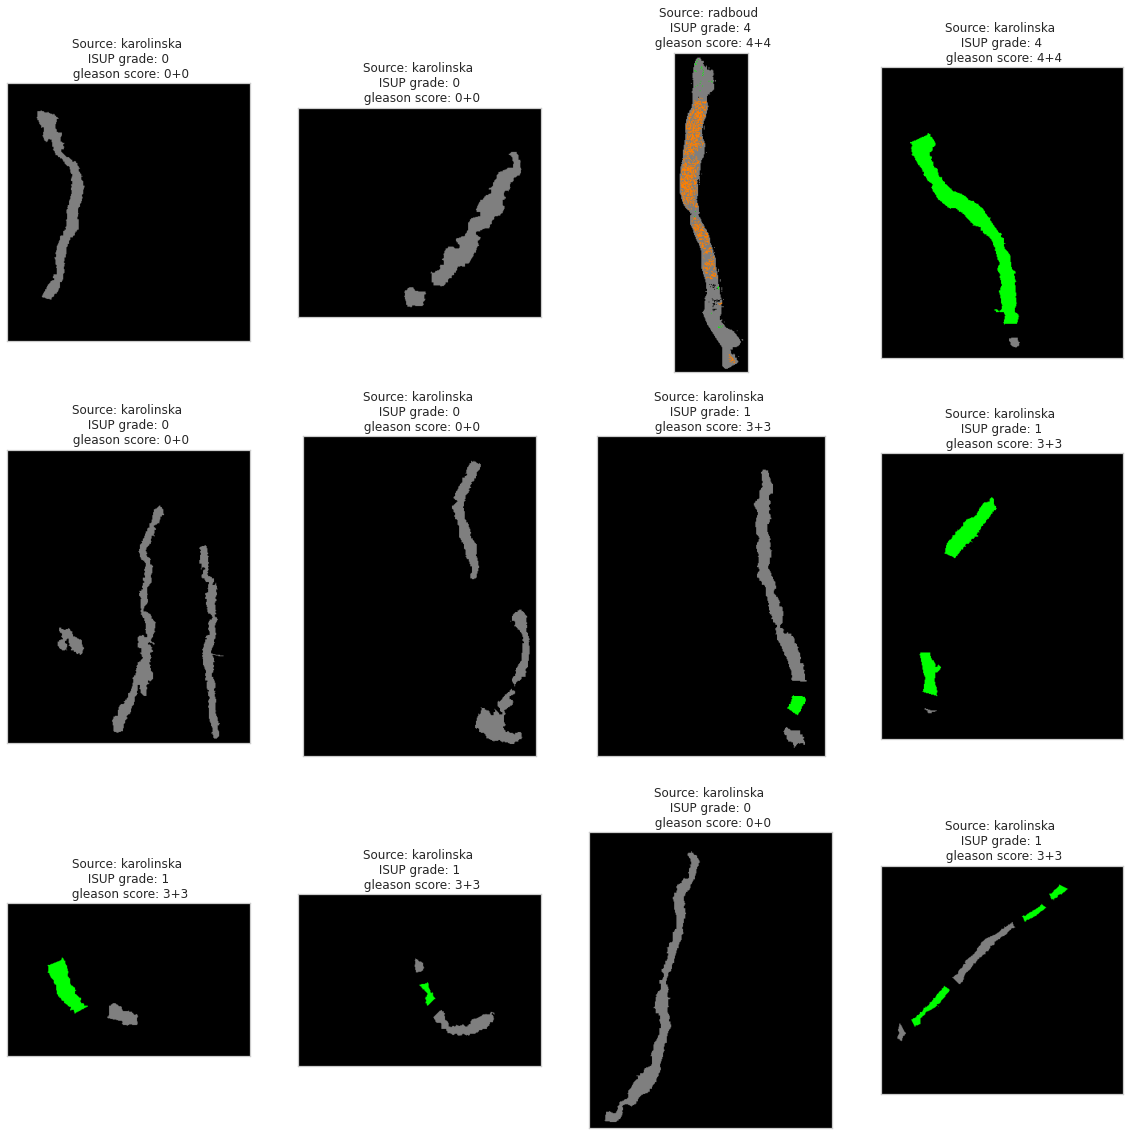

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 20))
count=0
for row in ax:
    for col in row:
        mask = os.path.join(BASE_DIR, 'train_label_masks', f'{train_df["image_id"].iloc[count]}_mask.tiff')
        mask = openslide.OpenSlide(mask)
        mask = print_mask_details(mask, center='radboud')
        col.imshow(mask)
        col.title.set_text(f'Source: {train_df["data_provider"].iloc[count]} \n ISUP grade: {train_df["isup_grade"].iloc[count]} \n gleason score: {train_df["gleason_score"].iloc[count]}')
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        mask.close()
        count += 1
plt.show()

## Visualizing some of the image patches from training dataset

In [19]:
def plot_patch(img, x, y, level=0, width=512, height=512):
    biopsy = openslide.OpenSlide(os.path.join(BASE_DIR, 'train_images', img))
    region = biopsy.read_region((x, y), level, (width, height))
    display(region)

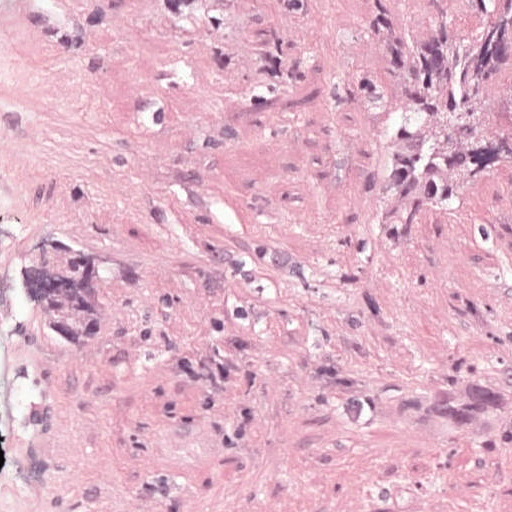

In [20]:
plot_patch('00928370e2dfeb8a507667ef1d4efcbb.tiff', 5150, 21000)

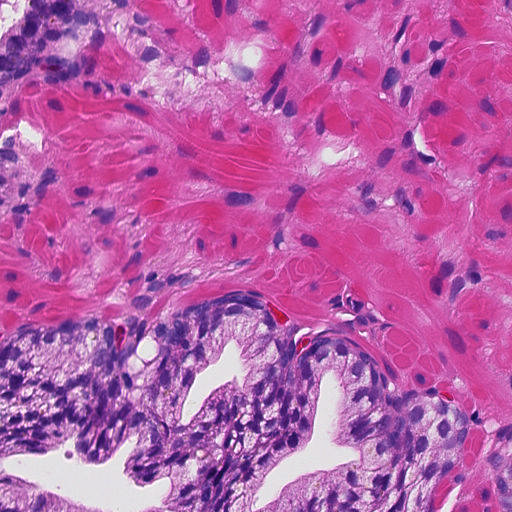

In [21]:
plot_patch('0005f7aaab2800f6170c399693a96917.tiff', 6000, 18000)

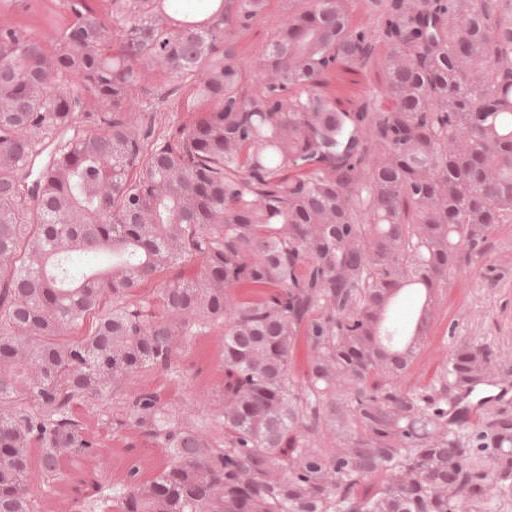

In [22]:
plot_patch('0018ae58b01bdadc8e347995b69f99aa.tiff', 1500, 6000)

## Visualizing biopsies having different ISUP grandes (Cancer Severitirs)

In [23]:
def plot_biopsy_grid(df):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
    count=0
    for row in ax:
        for col in row:
            img = os.path.join(BASE_DIR, 'train_images', f'{df["image_id"].iloc[count]}.tiff')
            img = openslide.OpenSlide(img)
            patch = img.read_region((0, 0), 2, img.level_dimensions[-1])
            col.title.set_text(f'Source: {df["data_provider"].iloc[count]} \n ISUP grade: {df["isup_grade"].iloc[count]} \n gleason score: {df["gleason_score"].iloc[count]}')
            col.grid(False)
            col.set_xticks([])
            col.set_yticks([])
            col.imshow(patch)
            count += 1
    plt.show()

### ISUP Grade: 0 (Risk Group: Healthy)

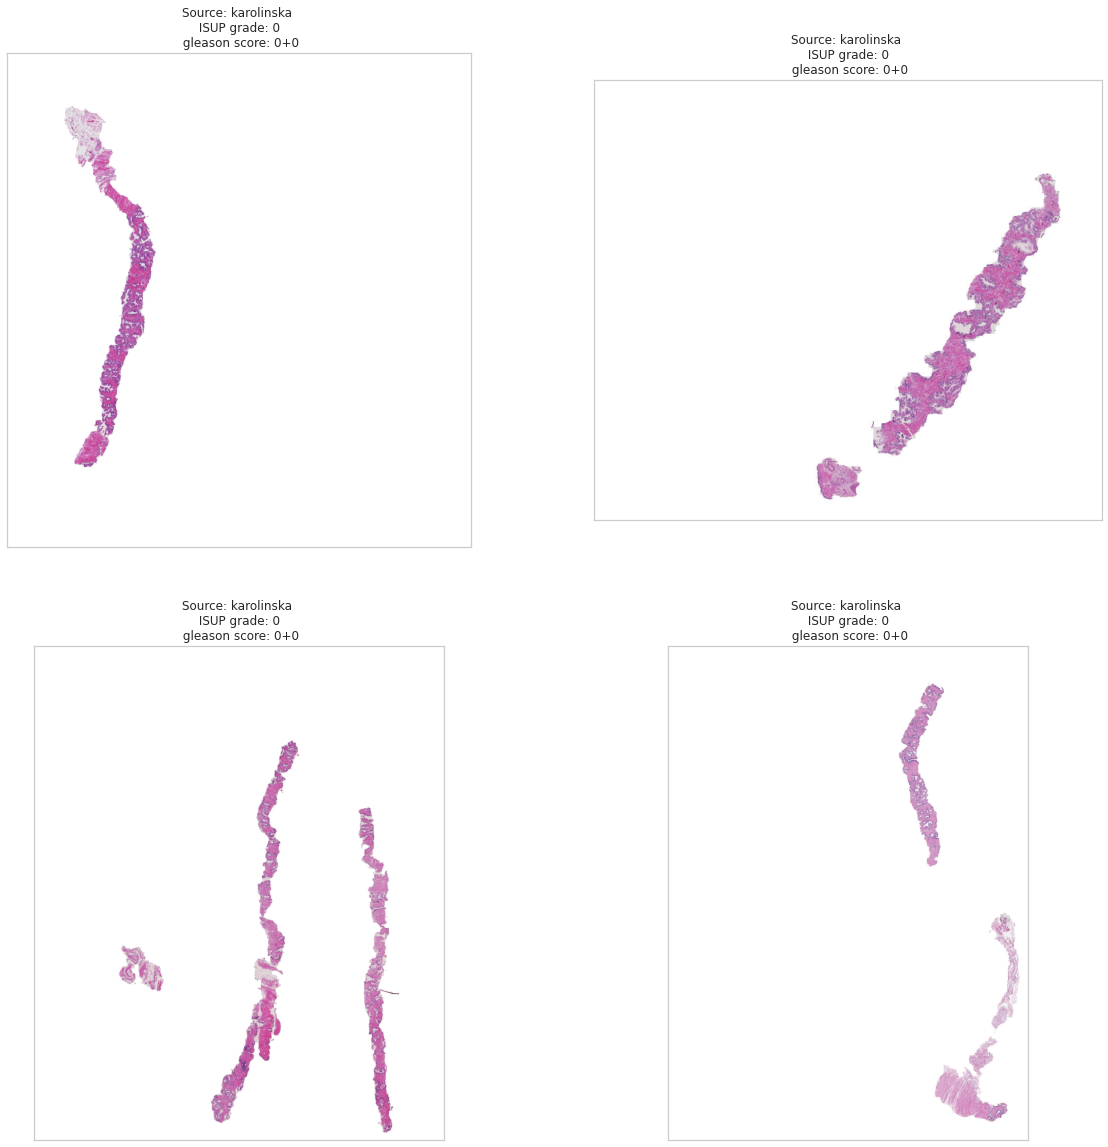

In [24]:
plot_biopsy_grid(train_df[train_df['isup_grade'] == 0][:4])

## ISUP Grade 1: (Risk Group: Low)

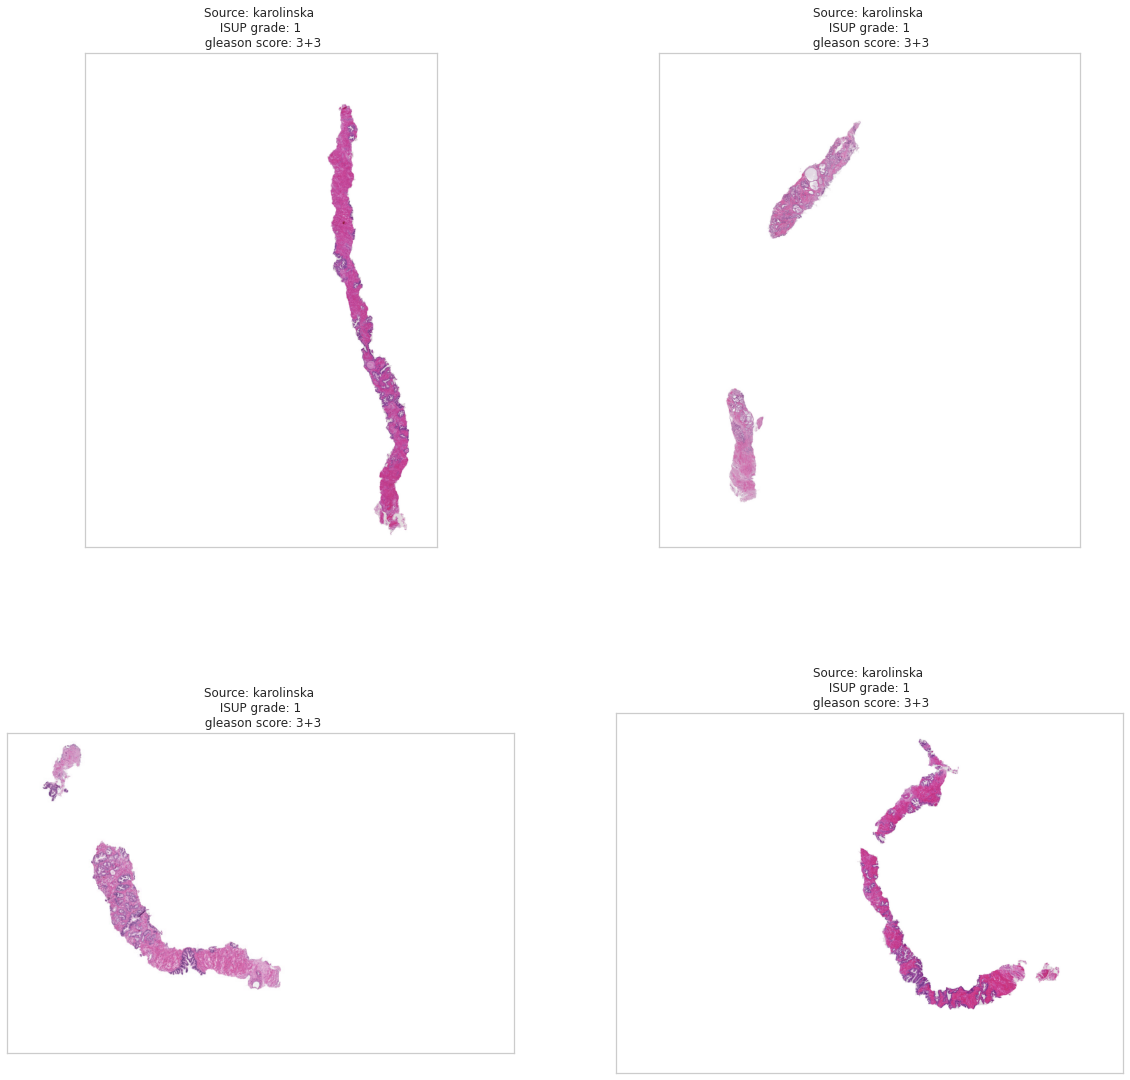

In [25]:
plot_biopsy_grid(train_df[train_df['isup_grade'] == 1][:4])

## ISUP Grade 2: (Risk Group: Intermediate Favorable)

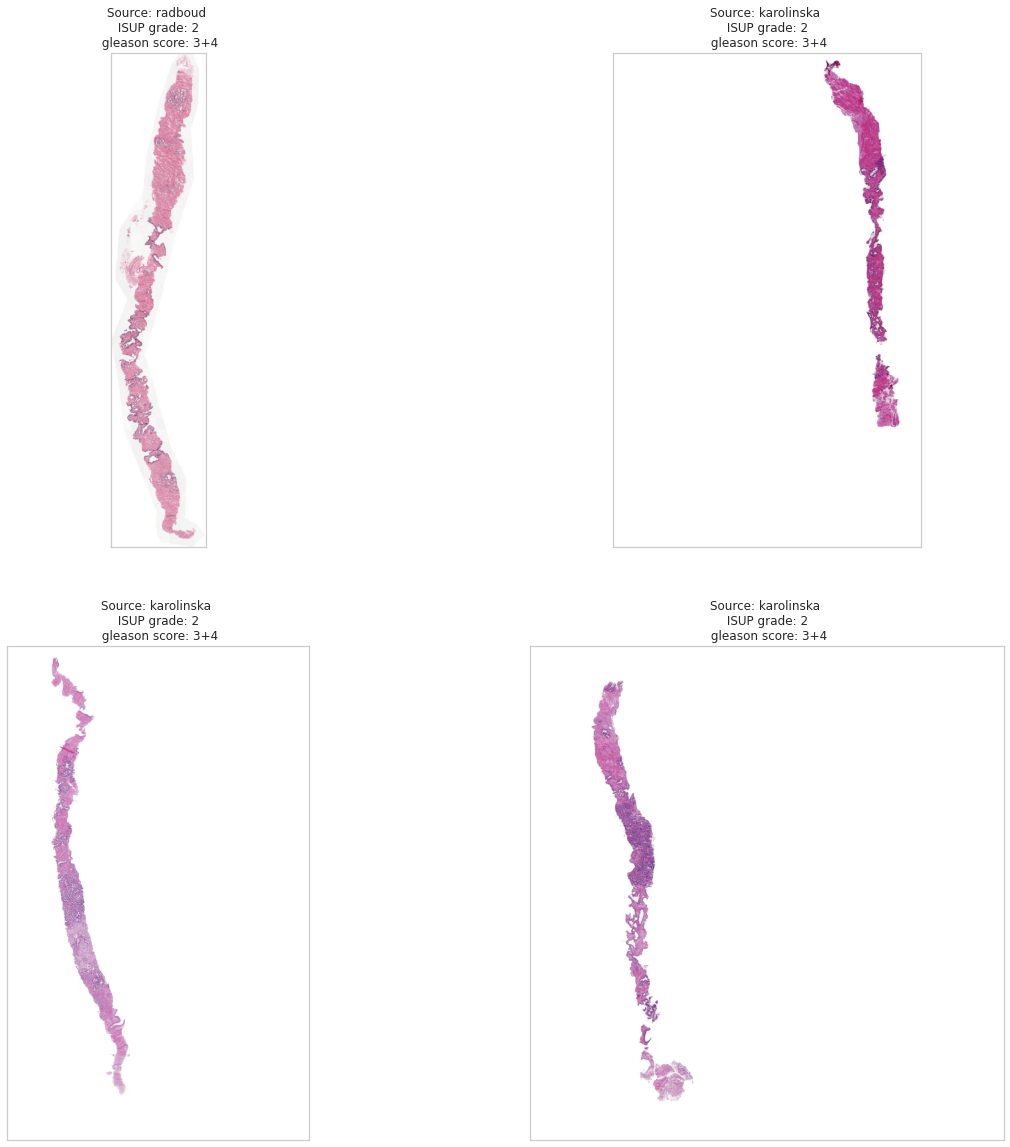

In [26]:
plot_biopsy_grid(train_df[train_df['isup_grade'] == 2][:4])

## ISUP Grade 3: (Risk Group: Intermediate Unfavorable)

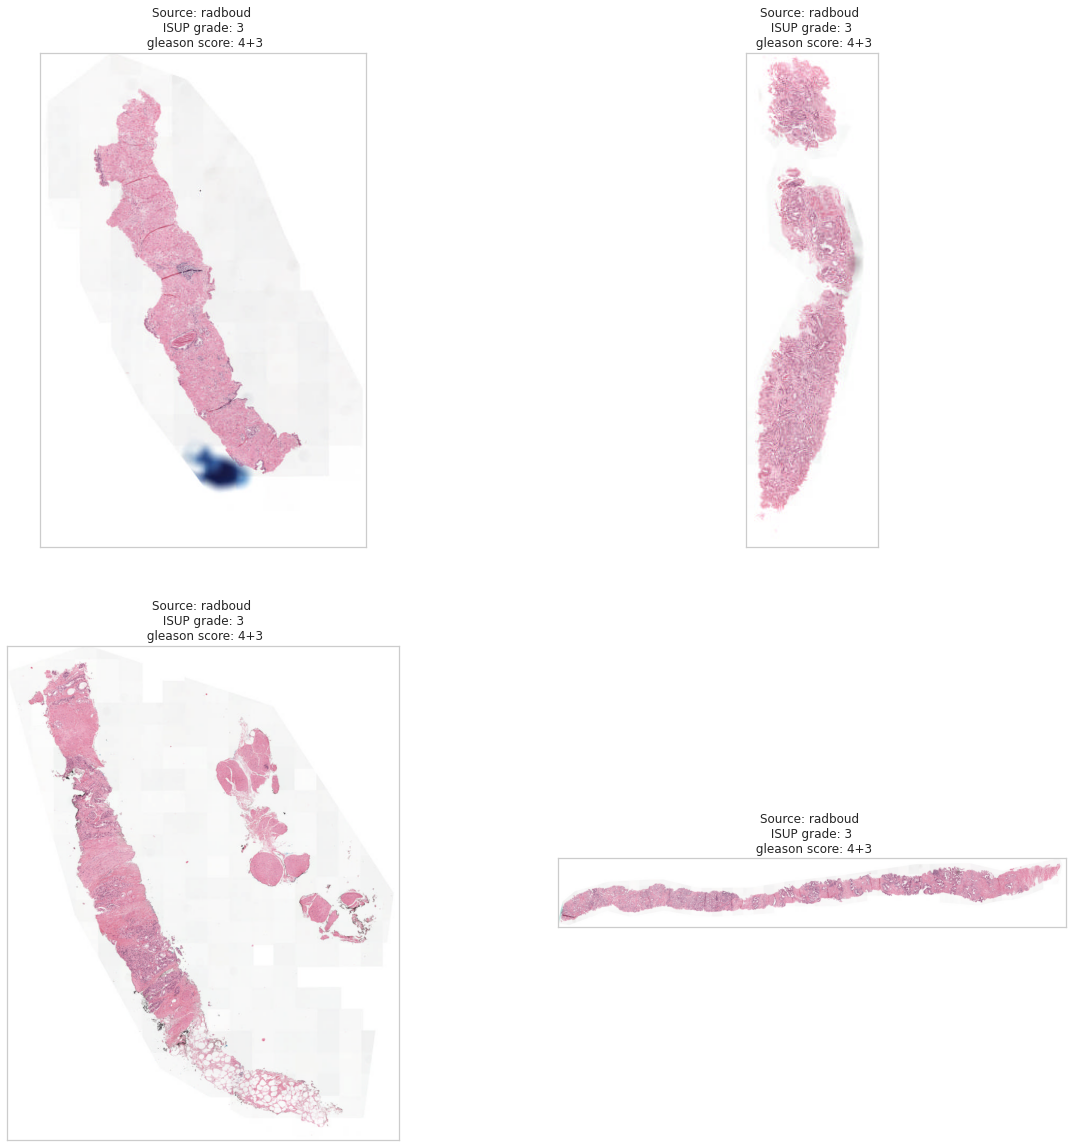

In [27]:
plot_biopsy_grid(train_df[train_df['isup_grade'] == 3][:4])

## ISUP Grade 4: (Risk Group: High)

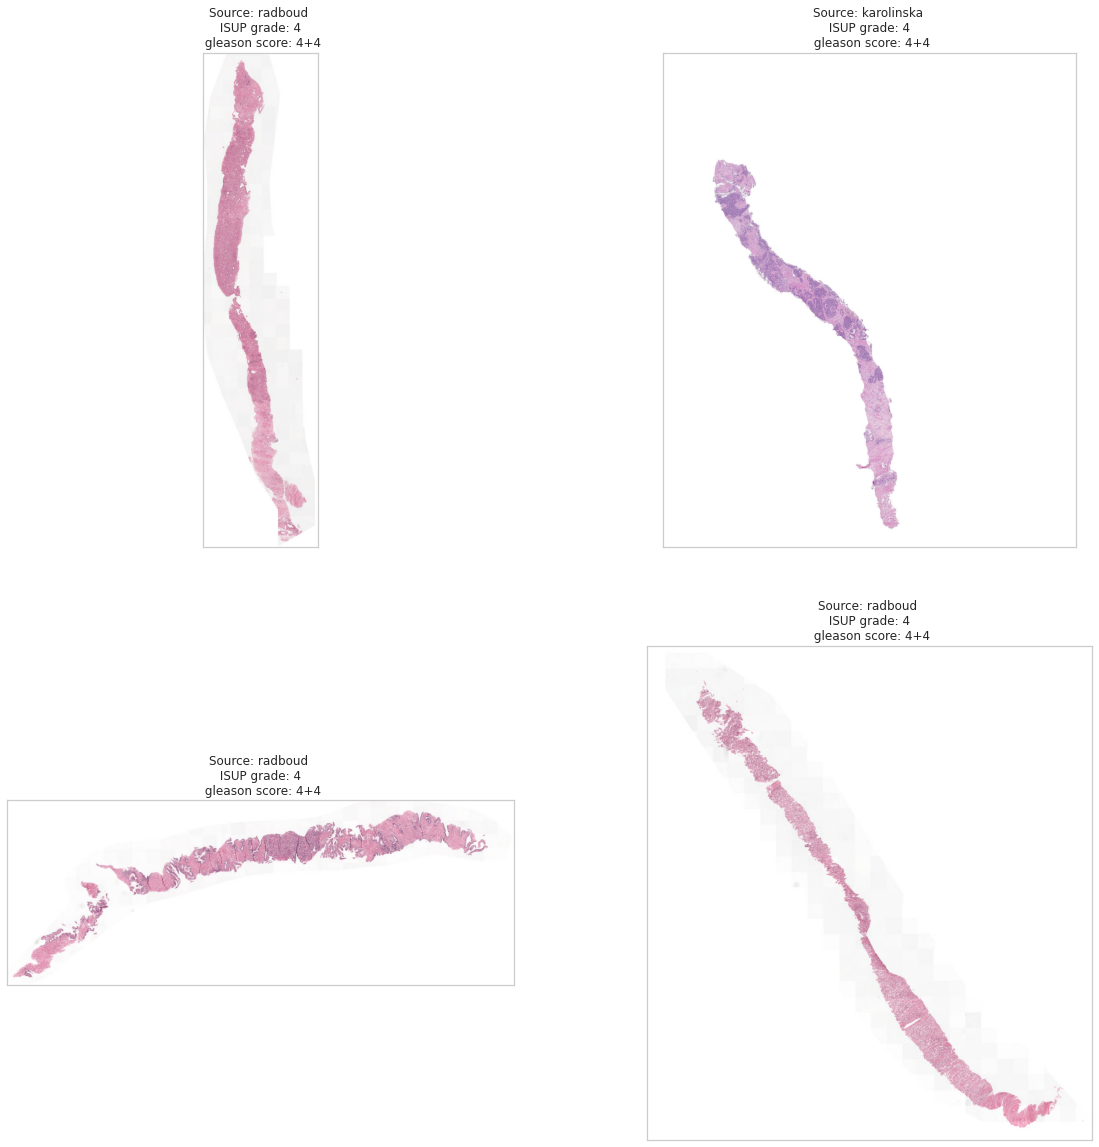

In [28]:
plot_biopsy_grid(train_df[train_df['isup_grade'] == 4][:4])

## ISUP Grade 5: (Risk Group: High)

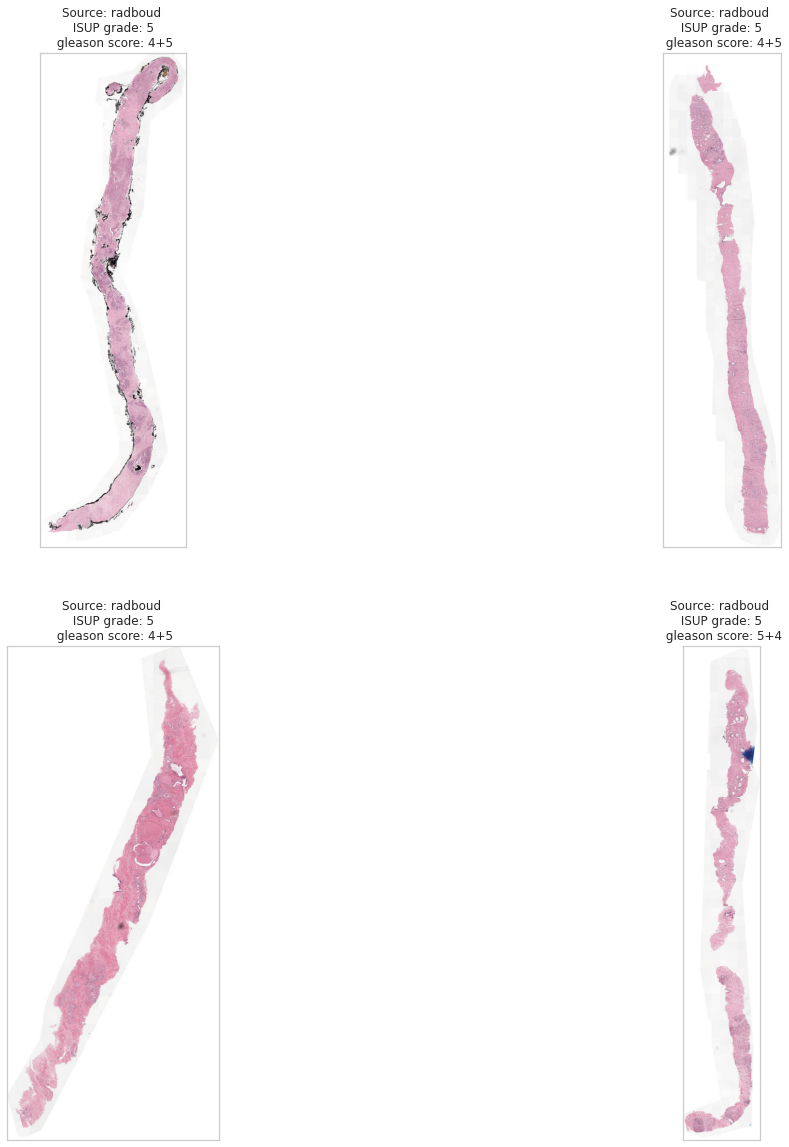

In [29]:
plot_biopsy_grid(train_df[train_df['isup_grade'] == 5][:4])

## Stay Tuned (In Progress)